# Import Packages 

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing
import matplotlib.pyplot as plt # Plotting
import seaborn as sns # Plotting

# Import Image Libraries - Pillow and OpenCV
from PIL import Image
import cv2

# Import PyTorch and useful fuctions
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision
import torch.optim as optim
import torchvision.models as models # Pre-Trained models
import random
# Import useful sklearn functions
import sklearn
from sklearn.metrics import cohen_kappa_score, accuracy_score

import time
from tqdm import tqdm_notebook
import sys 
import os
print(os.listdir("../input"))
base_dir = "../input/aptos2019-blindness-detection/"

['resnet101', 'aptos2019-blindness-detection', 'efficientnet', 'efficientnet-pytorch']


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set the Seed

In [3]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_no = 42
seed_everything(seed_no)

# Loading Data

In [4]:
# package_path = '../input/ResNet-101/resnet101.pth'

In [5]:
train_csv = pd.read_csv('../input/aptos2019-blindness-detection/train.csv')
test_csv = pd.read_csv('../input/aptos2019-blindness-detection/test.csv')
train_path = "../input/aptos2019-blindness-detection/train_images/"
test_path = "../input/aptos2019-blindness-detection/test_images/"

In [6]:
print('Train Size = {}'.format(len(train_csv)))
print('Public Test Size = {}'.format(len(test_csv)))

Train Size = 3662
Public Test Size = 1928


In [7]:
train_csv.head(2)

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4


In [8]:
# Data Class 
class CreateDataset(Dataset):
    def __init__(self, df_data, data_dir = '../input/', transform=None):
        super().__init__()
        self.df = df_data.values
        self.data_dir = data_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        img_name,label = self.df[index]
        img_path = os.path.join(self.data_dir, img_name+'.png')
        image = cv2.imread(img_path)
        if self.transform is not None:
            image = self.transform(image)
        return image, label
    

# Data Transformation

In [9]:
train_transforms = transforms.Compose([
transforms.ToPILImage(),
transforms.Resize((224, 224)),
#transforms.RandomHorizontalFlip(p=0.4),
#transforms.ColorJitter(brightness=2, contrast=2),
transforms.ToTensor(),
transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

In [10]:
 train_data = CreateDataset(df_data=train_csv, data_dir=train_path, transform=train_transforms)

In [11]:
# Set Batch Size
batch_size = 16

# Percentage of training set to use as validation
valid_size = 0.2

# train and valid dataset splitting 
num_train = len(train_data)
indices = np.random.permutation(num_train)
# indices = list(range(num_train))
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# Create Samplers
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = DataLoader(train_data, batch_size=batch_size, sampler=train_sampler)
valid_loader = DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler)

# Network Architecture

In [12]:
# baseline model 
model = models.resnet101(pretrained=False)
model.load_state_dict(torch.load("../input/resnet101/resnet101.pth"))
# for param in model.parameters():
#     param.requires_grad = False
model.avg_pool = nn.AdaptiveAvgPool2d(output_size=(1,1))
model.fc = nn.Sequential(
                nn.Linear(in_features=2048, out_features=1, bias=True),
#                 nn.Linear(in_features=1024, out_features=1, bias=True)
            )
# model.fc = nn.Sequential(
#                           nn.BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
#                           nn.Dropout(p=0.25),
#                           nn.Linear(in_features=2048, out_features=2048, bias=True),
#                           nn.ReLU(),
#                           nn.BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
#                           nn.Dropout(p=0.5),
#                           nn.Linear(in_features=2048, out_features=1, bias=True),
#                          )

In [13]:
# for name, child in model.named_children():
#     print(name)

In [14]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
    model.cuda()

CUDA is available!  Training on GPU ...


In [15]:
# Trainable Parameters
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of trainable parameters: \n{}".format(pytorch_total_params))

Number of trainable parameters: 
42502209


1. # Training and Validation

In [16]:
# specify loss function (categorical cross-entropy loss)
criterion = nn.MSELoss()

# specify optimizer
optimizer = optim.Adam(model.parameters(), lr=0.00015)

In [17]:
# number of epochs to train the model
n_epochs = 25

valid_loss_min = np.Inf

# keeping track of losses as it happen
train_losses = []
valid_losses = []
val_kappa = []
test_accuracies = []
valid_accuracies = []
kappa_epoch = []
batch = 0

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in tqdm_notebook(train_loader):
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda().float()
        target = target.view(-1, 1)
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        with torch.set_grad_enabled(True):
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
        # Update Train loss and accuracies
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in tqdm_notebook(valid_loader):
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda().float()
        # forward pass: compute predicted outputs by passing inputs to the model
        target = target.view(-1, 1)
        with torch.set_grad_enabled(True):
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
        #output = output.cohen_kappa_score_kappa_score)
        y_actual = target.data.cpu().numpy()
        y_pred = output[:,-1].detach().cpu().numpy()
        val_kappa.append(cohen_kappa_score(y_actual, y_pred.round()))        
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
    valid_kappa = np.mean(val_kappa)
    kappa_epoch.append(np.mean(val_kappa))
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
        
    # print training/validation statistics 
    print('Epoch: {} | Training Loss: {:.6f} | Val. Loss: {:.6f} | Val. Kappa Score: {:.4f}'.format(
        epoch, train_loss, valid_loss, valid_kappa))
    
    ##################
    # Early Stopping #
    ##################
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'best_model.pt')
        valid_loss_min = valid_loss


Epoch: 1 | Training Loss: 0.599597 | Val. Loss: 0.391144 | Val. Kappa Score: 0.5217
Validation loss decreased (inf --> 0.391144).  Saving model ...



Epoch: 2 | Training Loss: 0.367919 | Val. Loss: 0.616882 | Val. Kappa Score: 0.4882



Epoch: 3 | Training Loss: 0.237497 | Val. Loss: 0.367130 | Val. Kappa Score: 0.5261
Validation loss decreased (0.391144 --> 0.367130).  Saving model ...



Epoch: 4 | Training Loss: 0.172644 | Val. Loss: 0.404110 | Val. Kappa Score: 0.5037



Epoch: 5 | Training Loss: 0.164870 | Val. Loss: 0.444926 | Val. Kappa Score: 0.5228



Epoch: 6 | Training Loss: 0.114431 | Val. Loss: 0.307734 | Val. Kappa Score: 0.5420
Validation loss decreased (0.367130 --> 0.307734).  Saving model ...



Epoch: 7 | Training Loss: 0.077573 | Val. Loss: 0.312969 | Val. Kappa Score: 0.5609



Epoch: 8 | Training Loss: 0.061202 | Val. Loss: 0.292577 | Val. Kappa Score: 0.5716
Validation loss decreased (0.307734 --> 0.292577).  Saving model ...



Epoch: 9 | Training Loss: 0.061483 | Val. Loss: 0.322699 | Val. Kappa Score: 0.5818



Epoch: 10 | Training Loss: 0.053453 | Val. Loss: 0.326153 | Val. Kappa Score: 0.5847



Epoch: 11 | Training Loss: 0.048661 | Val. Loss: 0.296700 | Val. Kappa Score: 0.5928



Epoch: 12 | Training Loss: 0.041327 | Val. Loss: 0.308208 | Val. Kappa Score: 0.5955



Epoch: 13 | Training Loss: 0.037527 | Val. Loss: 0.297054 | Val. Kappa Score: 0.5997


# Loss Plotting 

In [18]:
pd.DataFrame({"kappa_epoch":kappa_epoch, "train_losses":train_losses, "valid_losses":valid_losses}).to_csv('result_loss.csv', index=None)

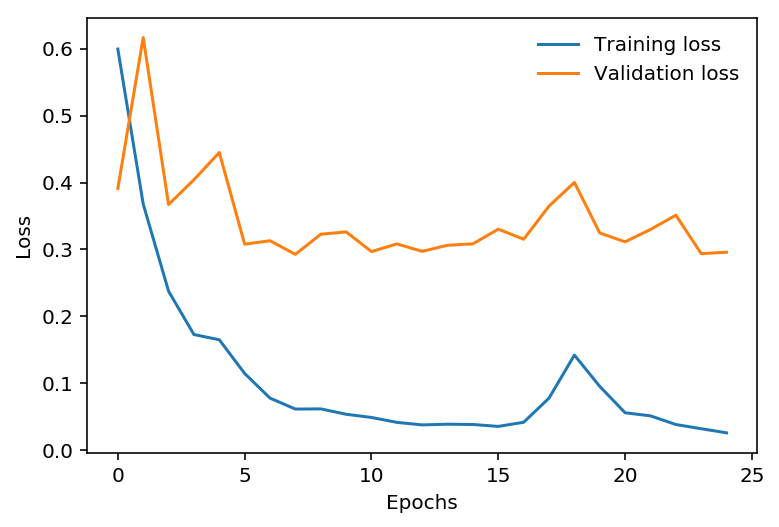

In [19]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(frameon=False)

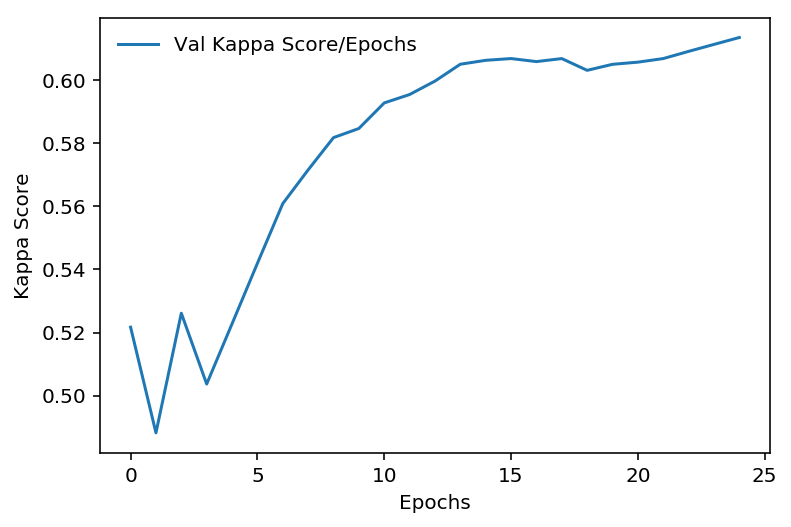

In [20]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.plot(kappa_epoch, label='Val Kappa Score/Epochs')
plt.legend("")
plt.xlabel("Epochs")
plt.ylabel("Kappa Score")
plt.legend(frameon=False) 

In [21]:
model.load_state_dict(torch.load('best_model.pt'))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

# Inference

In [22]:
test_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToPILImage(),
    torchvision.transforms.Resize((224, 224)),
    #torchvision.transforms.ColorJitter(brightness=2, contrast=2),
#     torchvision.transforms.RandomHorizontalFlip(p=0.5),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

In [23]:
test_csv['diagnosis'] = -1

In [24]:
test_data = CreateDataset(df_data=test_csv, data_dir=test_path, transform=test_transforms)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# Evaluation

In [25]:
 def round_off_preds(preds, coef=[0.5, 1.5, 2.5, 3.5]):
    for i, pred in enumerate(preds):
            if pred < coef[0]:
                preds[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                preds[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                preds[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                preds[i] = 3
            else:
                preds[i] = 4
    return preds

In [26]:
def predict(testloader):
    '''Function used to make predictions on the test set'''
    model.eval()
    preds = []
    for batch_i, (data, target) in enumerate(testloader):
        data, target = data.cuda(), target.cuda()
        output = model(data)
        pr = output.detach().cpu().numpy()
        for i in pr:
            preds.append(i.item())
            
    return preds

In [27]:
preds = round_off_preds(predict(test_loader))

# Generating Submission File

In [28]:
sample_sub = pd.read_csv('../input/aptos2019-blindness-detection/sample_submission.csv')

In [29]:
sample_sub.diagnosis = preds
sample_sub.diagnosis = sample_sub['diagnosis'].astype(int)

In [30]:
sample_sub.head()

,id_code,diagnosis
0,0005cfc8afb6,2
1,003f0afdcd15,3
2,006efc72b638,2
3,00836aaacf06,2
4,009245722fa4,2


In [31]:
sample_sub.to_csv('submission.csv', index=False)